<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment_2/blob/main/EE20S051_Assignment2B_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Finetuning a pretrained model 

In [3]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 43.6 MB/s 
     |████████████████████████████████| 144 kB 45.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8d42dc1d18b7417522c56a4c5b6120305f37fee94a1e2ec55217dba92242813a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [4]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [5]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

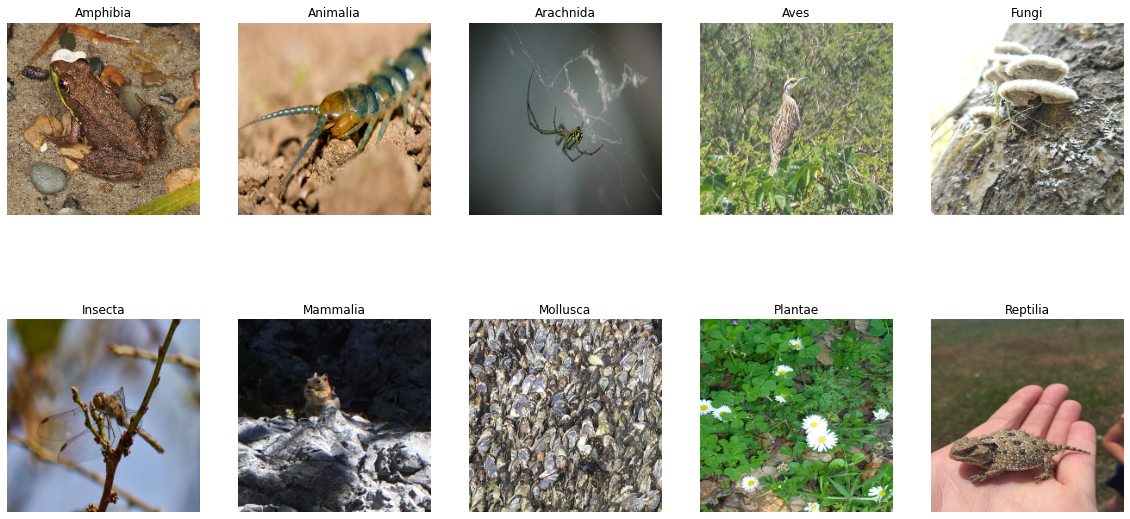

In [6]:
#visualizing images: one from each classes
fig = plt.figure(figsize=(20,10))
rows,columns= 2,5
i=1
for clas in classes: #10 unique classes
  dir=os.path.join(train_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    #image size
    #print(imgs.shape)
    new_img=cv2.resize(imgs,(224,224))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(clas)
    i+=1   
    break
 

In [16]:
def customized_dataGenerator(h,w):
    img_height,img_width= h ,w
    #data generators for train and validation set
    
    augment= ImageDataGenerator(
             rotation_range=30,
             width_shift_range=0.2,
             height_shift_range=0.2,
             shear_range=0.2,
             zoom_range=0.2,
             horizontal_flip=True,
             rescale=1.0 / 255,
             validation_split=0.1
             )

    datagen = ImageDataGenerator(
              rescale=1.0 / 255,
              validation_split=0.1
              )

    train_set = datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=32,
                color_mode='rgb',
                class_mode='sparse',
                shuffle=True,
                subset='training',
                seed=95,
                )
    aug_set= augment.flow_from_directory(
            train_dir,
            target_size=(img_height, img_width),
            batch_size=32,
            color_mode='rgb',
            class_mode='sparse',
            shuffle=True,
            subset='training',
            seed=95,
           )

    val_set= datagen.flow_from_directory(
              train_dir,
              target_size=(img_height, img_width),
              color_mode='rgb',
              class_mode='sparse',
              shuffle=True,
              subset='validation',
              seed=95,
              )
    return train_set, aug_set, val_set


In [7]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input,decode_predictions,VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [17]:
train_set, aug_set, val_set = customized_dataGenerator(224,224)

Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [8]:
model = VGG16(include_top = False,weights = 'imagenet',input_shape=(300,300,3))

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024,activation = 'relu')(flat1)
output = Dense(10,activation = 'softmax')(class1)
model = Model(inputs = model.inputs,outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [15]:
#visualizing images: one from each classes
#fig = plt.figure(figsize=(20,10))
#rows,columns= 2,5
i=1
for clas in classes: #10 unique classes
  dir=os.path.join(train_dir,clas)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    imgs=cv2.resize(imgs,(300,300))
    image = img_to_array(imgs)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    #image size
    #print(imgs.shape)
    #new_img=cv2.resize(imgs,(300,300))
    yhat = model.predict(image)
    #label = decode_predictions(yhat)
    print(yhat)
    i+=1   
    break
 

[[1.0252580e-09 4.4401248e-13 9.8929346e-01 1.1619874e-08 3.0751366e-22
  8.7167216e-09 7.3322474e-07 1.1546410e-07 7.0688719e-11 1.0705681e-02]]
[[7.4802493e-09 2.3316281e-06 1.9250224e-13 1.7577129e-07 1.8994879e-09
  4.6856138e-23 3.4827796e-10 9.9996448e-01 3.3017495e-05 4.4025516e-15]]
[[2.4609166e-05 4.6921353e-04 4.6500236e-01 1.5122388e-01 5.7307561e-04
  1.8716855e-06 3.4795296e-01 3.2150220e-02 7.5902914e-05 2.5258781e-03]]
[[7.9200984e-09 2.0313269e-10 8.5019559e-01 3.1388238e-02 3.6560908e-07
  1.3971395e-07 8.3933030e-14 4.3294992e-04 1.1798265e-01 7.7501089e-14]]
[[1.3703215e-03 1.8707053e-06 2.8532249e-06 8.9722034e-06 9.3928476e-12
  6.0430374e-08 6.9173765e-08 2.0140595e-07 9.8559618e-01 1.3019489e-02]]
[[1.15169385e-08 2.48009048e-04 1.03058980e-03 4.76672202e-01
  1.89833322e-08 1.62504360e-01 3.58167410e-01 2.71709694e-04
  1.10548385e-03 1.83138553e-07]]
[[6.6515298e-08 4.4784960e-03 6.0004788e-04 2.5674844e-02 6.4379037e-11
  9.9384219e-05 4.3120458e-06 9.6857834e

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )
#model.evaluate(val_set)

InvalidArgumentError: ignored